# Modeling seizure freedom (binary) using clinical data

## Import data

In [11]:
import pandas as pd

# Read dataframe from the pickle format
wide_df = pd.read_csv("../../data/processed/preprocessed_df.csv")

C:\Users\Amaury\AppData\Local\Temp\ipykernel_6760\4254179035.py:4: DtypeWarning: Columns (859,862) have mixed types. Specify dtype option on import or set low_memory=False.
  wide_df = pd.read_csv("../../data/processed/preprocessed_df.csv")


## Select features

In [12]:
# Selecting patients who only went through 1 surgery
wide_df = wide_df[wide_df["surgical_information"]==1]

X = wide_df[["sex_gender", "age", "eeg", "engel_outcomes", "mri", "phys_findings", "age_of_onset_hw", "eo_yrs_postsurg",
             "neuroanatomical_labeling", "neuropsychological_testing", "surg_stage", "neuro_findings", "eo_year_surg",
             "surgical_information", "freq_per_month_hw", "resect_procedure___1", "resect_procedure___2", "resect_procedure___3",
             "resect_procedure___4", "resect_procedure___5", "resect_procedure___6", "resect_procedure___7",
             "resect_procedure___8", "resect_procedure___9", "resect_procedure___10", "resect_procedure___11",
             "resect_procedure___12", "resect_procedure___14", "resect_procedure___15", "seizure_notes_word_cnt"]]

epilepsy_diagnosis = ["epi_dx_category", "epi_seiz_symp_idio", "epi_seiz_med_refract", "epi_seiz_se", "epi_icd", "epi_dx"] # "epi_dx" and "epi_key_information" for term frequency // Hot-encode the rest

past_medical_history = ["pmh_allergies", "pmh_non_aeds", "pmh_explanation", "pmh_dev_delay"] # "pmh_surg" // all except pmh_dev_delay for term frequency

seizure_classification = ["seiz_onset_lat", "seiz_onset_zone___1", "seiz_onset_zone___2", "seiz_onset_zone___3",
                          "seiz_onset_zone___4", "seiz_onset_zone___5", "seizure_class___1", "seizure_class___2",
                          "seizure_class___3", "seizure_class___4"] # Categorize or tf "seiz_onset_zone_oth" // One-Hot encode "seiz_onset_lat"

aed_history = ["prev_aeds", "prev_aeds_num"] + [f"prev_aeds_name___{i}" for i in range(1, 40)]# One-hot encode "prev_aeds" // "prev_aeds_num" is continuous (scaling)

# Select the handwritten columns as final columns (manually checked and annotated)
X = X.rename(columns={"age_of_onset_hw": "age_of_onset",
                      "freq_per_month_hw": "freq_per_month"})

X = pd.concat([X, wide_df[epilepsy_diagnosis]], axis=1)

# Fill NaN values with an empty string
X['epi_dx'] = X['epi_dx'].fillna('')

y = wide_df["surg_engel"]

# Turns the outcome variable from range [1,4] to [0,3]
y = y - 1

## One-hot encoding

One-hot encode the new columns from Epliepsy diagnosis information

In [13]:
# One-Hot Encoding for the first four columns
one_hot_encoded_df = pd.get_dummies(X, columns=["epi_dx_category", "epi_seiz_symp_idio", "epi_seiz_med_refract", "epi_seiz_se"])

# Convert textual categorical variable to category type
X['epi_icd'] = X['epi_icd'].astype('category')

# One-Hot Encoding for 'epi_icd'
X = one_hot_encoded_df.join(pd.get_dummies(X['epi_icd'], prefix='epi_icd'))

X = X.drop("epi_icd", axis=1)

print(X.info())


<class 'pandas.core.frame.DataFrame'>
Index: 390 entries, 0 to 577
Data columns (total 74 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sex_gender                  390 non-null    int64  
 1   age                         390 non-null    float64
 2   eeg                         390 non-null    float64
 3   engel_outcomes              390 non-null    float64
 4   mri                         390 non-null    float64
 5   phys_findings               376 non-null    float64
 6   age_of_onset                275 non-null    float64
 7   eo_yrs_postsurg             382 non-null    float64
 8   neuroanatomical_labeling    390 non-null    float64
 9   neuropsychological_testing  390 non-null    float64
 10  surg_stage                  389 non-null    float64
 11  neuro_findings              376 non-null    float64
 12  eo_year_surg                383 non-null    float64
 13  surgical_information        390 non-null

## Correlation matrix

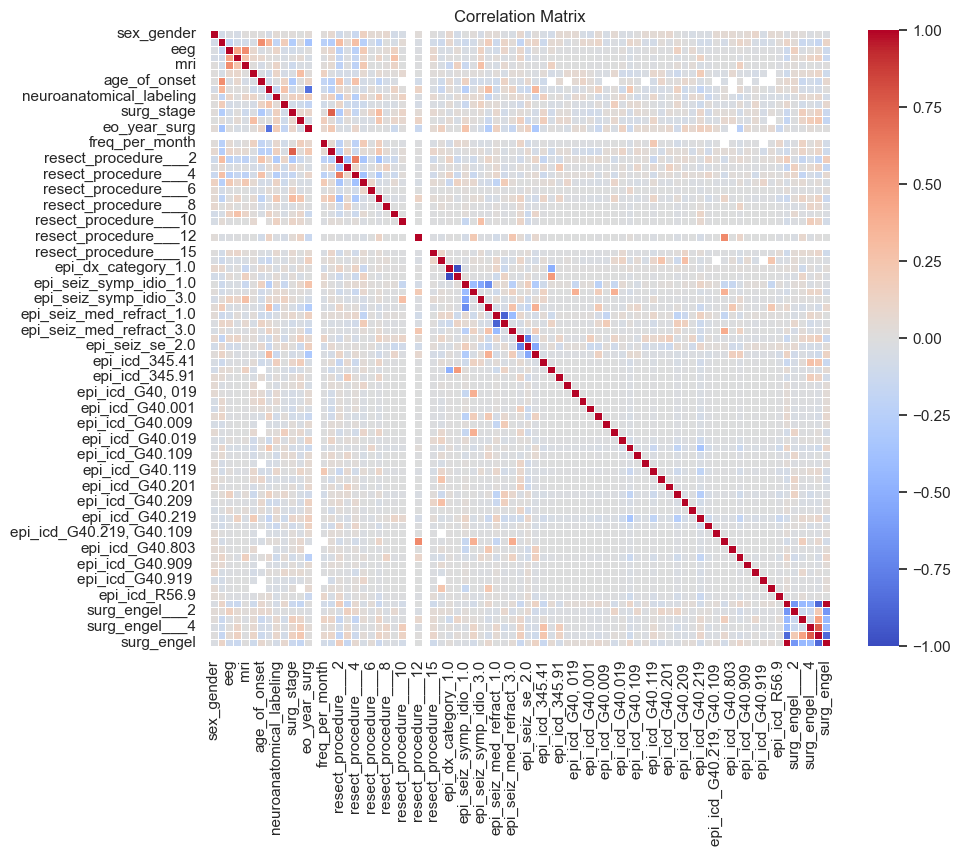

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

engel = wide_df[['surg_engel___1', 'surg_engel___2', 'surg_engel___3', 'surg_engel___4', 'surg_engel']]
engel = engel.rename(columns={'surg_engel': 'surg_engel_multi'})
y2 = y==0
engel = pd.concat([engel, y2], axis=1)

# Calculate the correlation matrix
correlation_matrix = pd.concat([X.drop("epi_dx", axis=1), engel], axis=1).corr()

# Create a heatmap using seaborn
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Create a boolean mask for rows with different values
mask = engel["surg_engel"] != engel["surg_engel___1"]

# Filter the DataFrame based on the mask
rows_with_different_values = engel[mask]

# Display rows with different values
print("\nRows with different values:")
print(rows_with_different_values)


Rows with different values:
Empty DataFrame
Columns: [surg_engel___1, surg_engel___2, surg_engel___3, surg_engel___4, surg_engel_multi, surg_engel]
Index: []


## To transform from a multiclass prediction to a single class prediction

In [6]:
# Trying to predict Engel class I
y = y==0

## Split data into train/test

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

## Term frequency analysis

In [8]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Create and fit a CountVectorizer
count_vectorizer = CountVectorizer(binary=True)  # binary=True will set all non-zero counts to 1
count_vectorizer.fit(X_train["epi_dx"])

# Transform the training and test data
X_train_count = count_vectorizer.transform(X_train["epi_dx"])
X_test_count = count_vectorizer.transform(X_test["epi_dx"])

# Convert to DataFrame
X_train_count_df = pd.DataFrame(X_train_count.toarray(), columns=count_vectorizer.get_feature_names_out())
X_test_count_df = pd.DataFrame(X_test_count.toarray(), columns=count_vectorizer.get_feature_names_out())

# Count non-zero entries for each feature in the training data
non_zero_counts = np.count_nonzero(X_train_count_df, axis=0)

# Create a Series from the counts
non_zero_series = pd.Series(non_zero_counts, index=X_train_count_df.columns)

# Sort the Series in descending order and select top 20
top_20_features = non_zero_series.sort_values(ascending=False).head(20).index

# Select columns from the DataFrames based on top 20 features
X_train_top_20 = X_train_count_df[top_20_features]
X_test_top_20 = X_test_count_df[top_20_features]

# These DataFrames now contain only the top 20 features with 0/1 values
print(X_train_top_20.head())


   epilepsy  partial  with  intractable  seizures  focal  complex  \
0         1        1     1            1         1      0        1   
1         1        0     0            0         0      0        0   
2         1        1     1            1         1      1        1   
3         1        1     1            1         1      0        1   
4         1        1     1            1         1      0        1   

   localization  related  status  epilepticus  without  of  epileptic  \
0             0        0       1            1        1   0          0   
1             1        1       0            0        0   1          0   
2             1        1       0            0        0   0          1   
3             0        0       1            1        1   0          0   
4             0        0       1            1        1   0          0   

   syndromes  and  symptomatic  consciousness  impairment  not  
0          0    0            1              0           0    0  
1          0    

In [9]:
# Remove the 'seizure_class_notes' column from X_train and X_test
X_train = X_train.drop('epi_dx', axis=1)
X_test = X_test.drop('epi_dx', axis=1)

# Filter out the top 10 TF-IDF features that have the same name as columns in X_train and X_test
common_columns = set(X_train.columns) & set(X_train_top_20.columns)
X_train_top_20_filtered = X_train_top_20.drop(columns=common_columns)
X_test_top_20_filtered = X_test_top_20.drop(columns=common_columns)

# Concatenate the filtered top 10 TF-IDF features with the modified X_train and X_test
X_train = pd.concat([X_train.reset_index(drop=True), X_train_top_20_filtered.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_top_20_filtered.reset_index(drop=True)], axis=1)

## 10-fold cross-validation

This step is done here in order to avoid data leakage of the scaling and imputing into the validation set used in the CV

c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


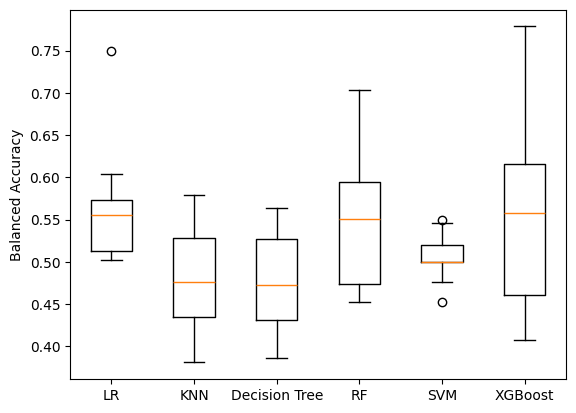

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month"]



column_names = numeric_var + list(set(X_train.columns) - set(numeric_var))

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define models
models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

results = []

# Loop through models
for model_name, model in models.items():
    # Create a pipeline with the preprocessor and the model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Create a stratified k-fold cross-validator
    kf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Cross-validate using the pipeline
    cv_results = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='balanced_accuracy')

    # Append cross-validation results to the results list
    results.append(cv_results)

# Plot the results
plt.boxplot(results, labels=models.keys())
plt.ylabel('Balanced Accuracy')
plt.show()

### Nested CV with hyperparameter tuning

In the following, I plotted the AUC score for a few models after preprocessing, feature selection and hyperparameter tuning.

The inner CV is for hyperparameter tuning while the outer CV is for scoring.

c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1250 fits failed out of a total of 6250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1250 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ama

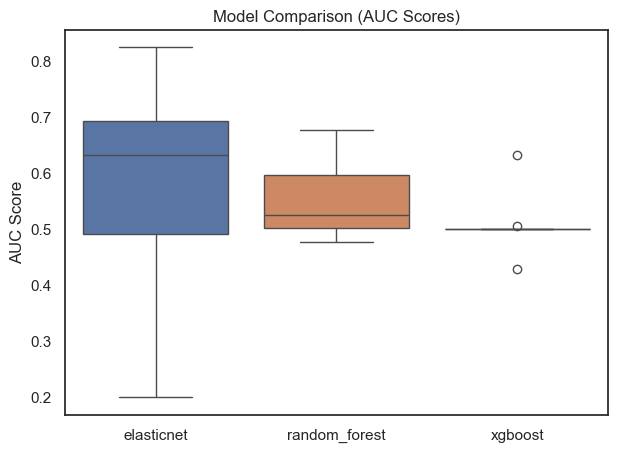

Selected Features for elasticnet: [['sex_gender', 'age', 'phys_findings', 'age_of_onset', 'freq_per_month', 'resect_procedure___1'], ['sex_gender', 'age', 'eeg', 'engel_outcomes', 'mri', 'phys_findings', 'age_of_onset', 'eo_yrs_postsurg', 'neuroanatomical_labeling', 'neuropsychological_testing', 'surg_stage', 'neuro_findings', 'eo_year_surg', 'surgical_information', 'freq_per_month', 'resect_procedure___1', 'resect_procedure___2', 'resect_procedure___3', 'resect_procedure___4', 'resect_procedure___5', 'resect_procedure___6', 'resect_procedure___7', 'resect_procedure___8', 'resect_procedure___9', 'resect_procedure___10', 'resect_procedure___11', 'resect_procedure___12', 'resect_procedure___14', 'resect_procedure___15', 'seizure_notes_word_cnt', 'epi_dx_category_1.0', 'epi_dx_category_2.0', 'epi_seiz_symp_idio_1.0', 'epi_seiz_symp_idio_2.0', 'epi_seiz_symp_idio_3.0', 'epi_seiz_symp_idio_4.0', 'epi_seiz_med_refract_1.0', 'epi_seiz_med_refract_2.0', 'epi_seiz_med_refract_3.0', 'epi_seiz_se

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import ElasticNet, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

X_CV = X_train
y_CV = y_train

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month"]

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define model pipelines with named steps and feature selection
model_pipelines = {
    'elasticnet': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(ElasticNet())),
        ('model', ElasticNet())
    ]),
    'random_forest': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('model', RandomForestClassifier())
    ]),
    'xgboost': Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', SelectFromModel(XGBClassifier(use_label_encoder=False, eval_metric='logloss'))),
        ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
    ])
    #'svm': Pipeline([
    #    ('preprocessor', preprocessor),
    #    ('feature_selection', SelectFromModel(SVC(kernel="linear"))),
    #    ('model', SVC())
    #])
}

# Define hyperparameter grids for each model
models_and_parameters = {
    'elasticnet': {'feature_selection__estimator__alpha': np.linspace(0.1, 1, 5), 
                   'feature_selection__estimator__l1_ratio': np.linspace(0.1, 1, 5),
                   'model__alpha': np.linspace(0.1, 1, 5), 
                   'model__l1_ratio': np.linspace(0.1, 1, 5)},
    'random_forest': {'feature_selection__estimator__n_estimators': [20, 50], 
                      'model__n_estimators': [20, 50], 
                      'model__max_depth': [5, 10]},
    'xgboost': {'feature_selection__estimator__n_estimators': [20, 50], 
                'model__n_estimators': [20, 50], 
                'model__learning_rate': np.logspace(-3, -1, 3)}
    #'svm': {'feature_selection__estimator__C': np.logspace(-3, 2, 6),
    #        'model__C': np.logspace(-3, 2, 6),
    #        'model__kernel': ['linear', 'rbf', 'poly'],
    #        'model__gamma': ['scale', 'auto']}
}

# Perform nested cross-validation and store selected features
outer_cv = StratifiedKFold(n_splits=10)
inner_cv = StratifiedKFold(n_splits=10)
results = {}
selected_features = {}
best_params = {}

for model_name, pipeline in model_pipelines.items():
    param_grid = models_and_parameters[model_name]
    auc_scores = []
    features_selected = []
    params = []

    for train_idx, test_idx in outer_cv.split(X_CV, y_CV):
        X_train_fold, X_test_fold = X_CV.iloc[train_idx], X_CV.iloc[test_idx]
        y_train_fold, y_test_fold = y_CV.iloc[train_idx], y_CV.iloc[test_idx]

        # Inner CV for hyperparameter tuning
        grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train_fold, y_train_fold)

        # Best model and parameters
        best_model = grid_search.best_estimator_
        params.append(grid_search.best_params_)

        # Evaluate on test set
        y_pred = best_model.predict(X_test_fold)
        auc_score = roc_auc_score(y_test_fold, y_pred)
        auc_scores.append(auc_score)

        # Store selected features
        selected_mask = best_model.named_steps['feature_selection'].get_support()
        features = list(X_CV.columns[selected_mask])
        features_selected.append(features)

    results[model_name] = auc_scores
    selected_features[model_name] = features_selected
    best_params[model_name] = params

# Convert results to a DataFrame for easier plotting
all_scores = pd.DataFrame(results)

# Plot AUC scores
plt.figure(figsize=(7, 5))
sns.boxplot(data=all_scores)
plt.title('Model Comparison (AUC Scores)')
plt.ylabel('AUC Score')
plt.show()

# Print selected features and best parameters
for model in selected_features:
    print(f"Selected Features for {model}: {selected_features[model]}")
    print(f"Best Parameters for {model}: {best_params[model]}")

Now let's focus on the elasticnet

c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1000 fits failed out of a total of 6250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Amaury\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Amau

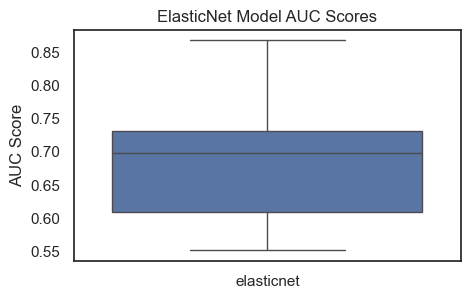

Selected Features for ElasticNet: [['sex_gender', 'age', 'phys_findings', 'surg_stage', 'resect_procedure___1', 'resect_procedure___3'], ['sex_gender', 'age', 'eeg', 'engel_outcomes', 'mri', 'phys_findings', 'age_of_onset', 'eo_yrs_postsurg', 'neuroanatomical_labeling', 'neuropsychological_testing', 'surg_stage', 'neuro_findings', 'eo_year_surg', 'surgical_information', 'freq_per_month', 'resect_procedure___1', 'resect_procedure___2', 'resect_procedure___3', 'resect_procedure___4', 'resect_procedure___5', 'resect_procedure___6', 'resect_procedure___7', 'resect_procedure___8', 'resect_procedure___9', 'resect_procedure___10', 'resect_procedure___11', 'resect_procedure___12', 'resect_procedure___14', 'resect_procedure___15', 'seizure_notes_word_cnt', 'seizure', 'of', 'onset', 'hx', 'and', 'seizures', 'in', 'to', 'birth', 'at', 'no', 'months', 'triggers', 'developmental', 'normal', 'febrile', 'clusters', 'with', 'history'], ['sex_gender', 'age', 'eeg', 'engel_outcomes', 'mri', 'phys_findin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score

X_CV = X_train
y_CV = y_train

# List of continuous and non-continuous variables
numeric_var = ["age", "age_of_onset", "eo_yrs_postsurg", "eo_year_surg", "seizure_notes_word_cnt",
               "eeg", "engel_outcomes", "mri", "neuroanatomical_labeling",
               "neuropsychological_testing", "surgical_information", "freq_per_month"]

# Define preprocessing pipelines
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
categorical_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'))

# Define the preprocessing pipeline
preprocessor = make_column_transformer(
    (numeric_pipe, numeric_var),
    remainder=categorical_pipe
)

# Define model pipeline with named steps and feature selection for ElasticNet
elasticnet_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(ElasticNet())),
    ('model', ElasticNet())
])

# Define hyperparameter grid for ElasticNet
elasticnet_parameters = {
    'feature_selection__estimator__alpha': np.linspace(0.1, 10, 5), 
    'feature_selection__estimator__l1_ratio': np.linspace(0.1, 1, 5),
    'model__alpha': np.linspace(0.1, 1, 5), 
    'model__l1_ratio': np.linspace(0.1, 1, 5)
}

# Perform nested cross-validation and store selected features
outer_cv = StratifiedKFold(n_splits=10)
inner_cv = StratifiedKFold(n_splits=10)

auc_scores = []
features_selected = []
best_params = []

for train_idx, test_idx in outer_cv.split(X_CV, y_CV):
    X_train_fold, X_test_fold = X_CV.iloc[train_idx], X_CV.iloc[test_idx]
    y_train_fold, y_test_fold = y_CV.iloc[train_idx], y_CV.iloc[test_idx]

    # Inner CV for hyperparameter tuning
    grid_search = GridSearchCV(elasticnet_pipeline, elasticnet_parameters, cv=inner_cv, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_fold, y_train_fold)

    # Best model and parameters
    best_model = grid_search.best_estimator_
    best_params.append(grid_search.best_params_)

    # Evaluate on test set
    y_pred = best_model.predict(X_test_fold)
    auc_score = roc_auc_score(y_test_fold, y_pred)
    auc_scores.append(auc_score)

    # Store selected features
    selected_mask = best_model.named_steps['feature_selection'].get_support()
    features = list(X_CV.columns[selected_mask])
    features_selected.append(features)

# Convert results to a DataFrame for easier plotting
all_scores = pd.DataFrame({'elasticnet': auc_scores})

# Plot AUC scores
plt.figure(figsize=(5, 3))
sns.boxplot(data=all_scores)
plt.title('ElasticNet Model AUC Scores')
plt.ylabel('AUC Score')
plt.show()

# Print selected features and best parameters for ElasticNet
print(f"Selected Features for ElasticNet: {features_selected}")
print(f"Best Parameters for ElasticNet: {best_params}")


## Scale continuous variables

In [15]:
# Fit and transform on training and testing data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

## Null accuracy

In [16]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

# Create a DummyClassifier that always predicts the most frequent class
dummy_classifier = DummyClassifier(strategy='most_frequent')

# Fit the DummyClassifier on the training data
dummy_classifier.fit(X_train, y_train)

# Make predictions on the training data
y_pred_dummy = dummy_classifier.predict(X_train)

# Calculate null accuracy
null_accuracy = accuracy_score(y_train, y_pred_dummy)

print(f"Null Accuracy: {null_accuracy:.2f}")

Null Accuracy: 0.68


## ROC AND AUC

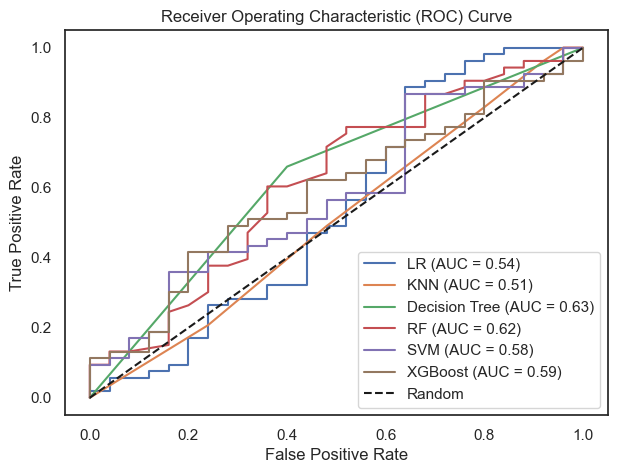

In [17]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models = {
    "LR": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "SVM": SVC(max_iter=2000, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
}

plt.figure(figsize=(7, 5))

for name, model in models.items():
    # Fit the model on the training data
    model.fit(X_train_scaled, y_train)

    # Check if the model has predict_proba method
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # For models without predict_proba, use decision function
        y_pred_prob = model.decision_function(X_test_scaled)

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression classifier
lr = LogisticRegression(max_iter=2000, random_state=42)

# Train the classifier on the training data
lr.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63


### Logistic Regression Coefficients

\begin{equation}
P(Y=1) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + \beta_2x_2 + \ldots + \beta_nx_n)}}
\end{equation}

* Positive Coefficient: A positive coefficient for a feature means that an increase in that feature's value is associated with an increase in the log-odds of the response variable being in the positive class.

* Negative Coefficient: A negative coefficient for a feature means that an increase in that feature's value is associated with a decrease in the log-odds of the response variable being in the positive class.

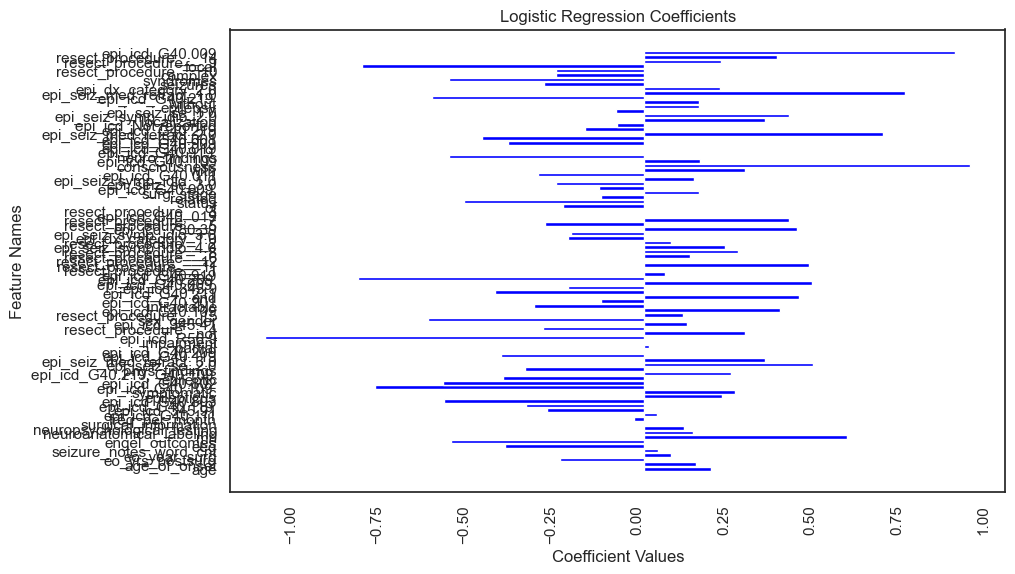

In [19]:
import numpy as np

# Get the coefficients and feature names
coefficients = lr.coef_.flatten()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(column_names, coefficients, color='blue')
plt.xlabel('Coefficient Values')
plt.ylabel('Feature Names')
plt.title('Logistic Regression Coefficients')
plt.xticks(rotation=90, ha="right")
plt.show()

In [20]:
# Get the intercept and coefficients
intercept = lr.intercept_[0]
coefficients = lr.coef_[0]

# Display the logistic regression equation
equation = f"P(Y=1) = 1 / (1 + e^(-({intercept:.4f} + "
for feature, coefficient in zip(numeric_var, coefficients):
    equation += f"{coefficient:.4f} * {feature} + "
equation = equation[:-2]  # Remove the trailing ' + '
equation += ")))"

print("Logistic Regression Equation:")
print(equation)


Logistic Regression Equation:
P(Y=1) = 1 / (1 + e^(-(2.8867 + 0.1937 * age + 0.1490 * age_of_onset + -0.2445 * eo_yrs_postsurg + 0.0763 * eo_year_surg + 0.0408 * seizure_notes_word_cnt + -0.4019 * eeg + -0.5574 * engel_outcomes + 0.5838 * mri + 0.1418 * neuroanatomical_labeling + 0.1144 * neuropsychological_testing + 0.0000 * surgical_information + -0.0308 * freq_per_month )))


### Feature selection

Shows important features by applying LASSO regression (L1 regularization) to penalize the absolute size of coefficients. This tends to shrink some coefficients to zero, effectively selecting a subset of features.

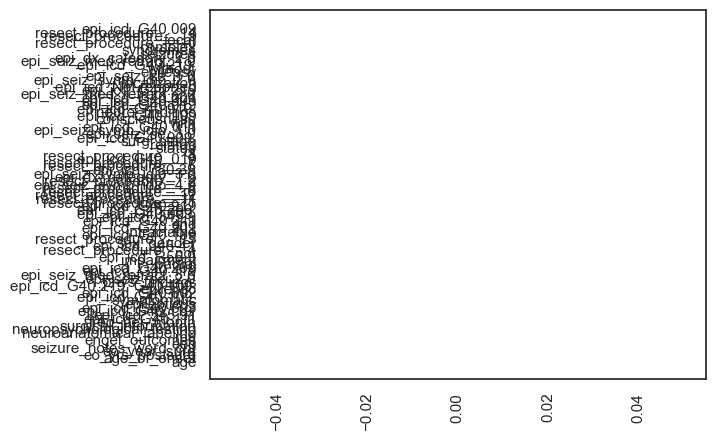

In [21]:
from sklearn.linear_model import Lasso
import numpy as np
import matplotlib.pyplot as plt

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(X_train_scaled, y_train).coef_

# Filter out columns with coefficient equal to 0
nonzero_coef_indices = np.where(lasso_coef != 0)[0]
nonzero_names = [column_names[i] for i in nonzero_coef_indices]  # Use a list comprehension to get the names
nonzero_coef = lasso_coef[nonzero_coef_indices]

plt.barh(column_names, lasso_coef)
plt.xticks(rotation=90)
plt.show()

## Decision Tree classifier

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier(max_depth = 3, random_state=42)

# Turn outcome variable into dummy variables
y_train_encoded = pd.get_dummies(y_train, columns=["surg_engel"], drop_first=True)
y_test_encoded = pd.get_dummies(y_test, columns=["surg_engel"], drop_first=True)

# Train the classifier on the training data
clf.fit(X_train, y_train_encoded)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.56


### Plot decision tree

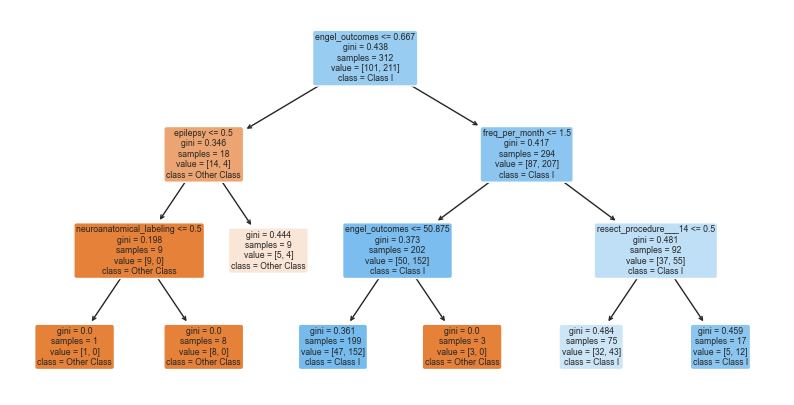

In [23]:
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(10, 5))
plot_tree(clf, filled=True, feature_names=column_names, class_names=["Other Class", "Class I"], rounded=True)
plt.show()

## Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.68


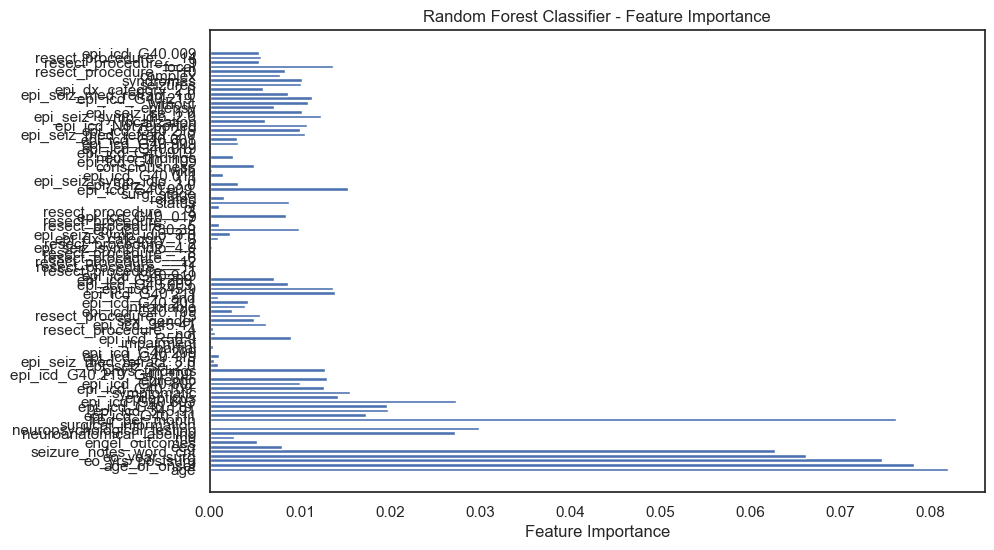

In [25]:
# Get feature importances from the trained Random Forest model
feature_importances = rf.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("Random Forest Classifier - Feature Importance")
plt.show()

## Support Vector Machines (SVM)

In [26]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
svc = SVC(kernel='linear', C=1, random_state=42)

# Train the classifier on the training data
svc.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = svc.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.65


Positive coefficients indicate that the corresponding features are positively correlated with the target class, while negative coefficients indicate a negative correlation.

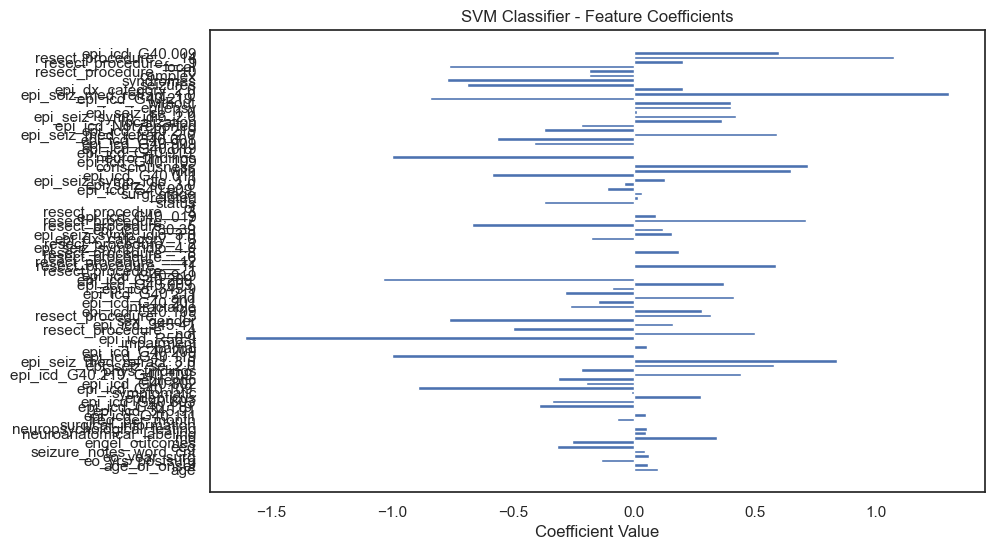

In [27]:
# Get the coefficients (weights) from the trained SVM model
coefficients = svc.coef_.flatten()

# Create a bar plot of feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(range(len(coefficients)), coefficients, align="center")
plt.yticks(range(len(coefficients)), column_names)
plt.xlabel("Coefficient Value")
plt.title("SVM Classifier - Feature Coefficients")
plt.show()

In [28]:
(X_train["engel_outcomes"]==2).sum()

3

## XGBoost

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Train the classifier on the training data
xgb.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test_scaled)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.60


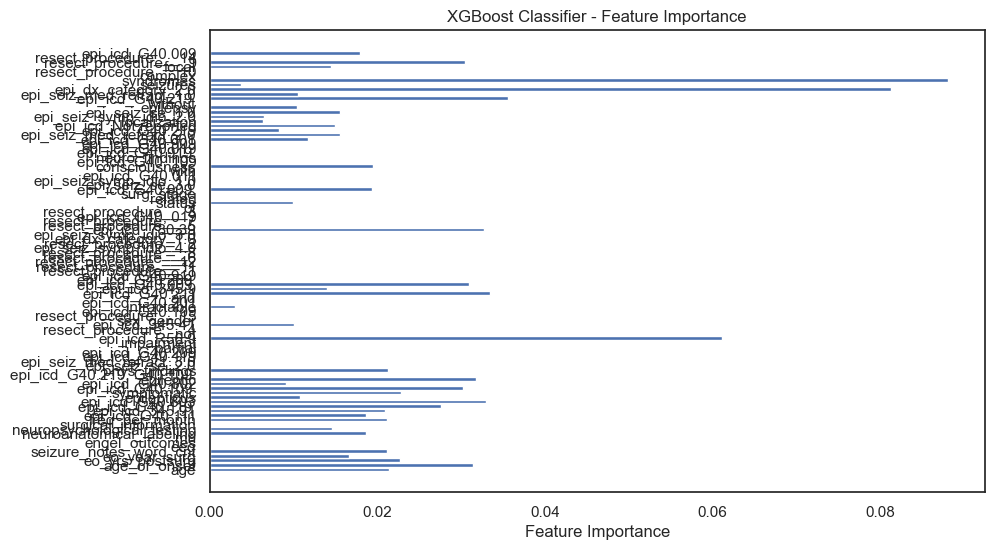

In [30]:
# Get feature importances from the trained XGBoost model
feature_importances = xgb.feature_importances_

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align="center")
plt.yticks(range(len(feature_importances)), column_names)
plt.xlabel("Feature Importance")
plt.title("XGBoost Classifier - Feature Importance")
plt.show()

## Neural Network

In [31]:
import tensorflow as tf

# Create a simple neural network model using Keras for binary classification
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training data
model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=2)

# Make predictions on the test data
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")





Epoch 1/5


8/8 - 2s - loss: 0.6639 - accuracy: 0.6867 - val_loss: 0.6213 - val_accuracy: 0.6984 - 2s/epoch - 204ms/step
Epoch 2/5
8/8 - 0s - loss: 0.6312 - accuracy: 0.6707 - val_loss: 0.6017 - val_accuracy: 0.6984 - 61ms/epoch - 8ms/step
Epoch 3/5
8/8 - 0s - loss: 0.6176 - accuracy: 0.6707 - val_loss: 0.5944 - val_accuracy: 0.6984 - 55ms/epoch - 7ms/step
Epoch 4/5
8/8 - 0s - loss: 0.6053 - accuracy: 0.6707 - val_loss: 0.5909 - val_accuracy: 0.6984 - 51ms/epoch - 6ms/step
Epoch 5/5
8/8 - 0s - loss: 0.5900 - accuracy: 0.6827 - val_loss: 0.5860 - val_accuracy: 0.7302 - 53ms/epoch - 7ms/step
3/3 [==============================] - 0s 2ms/step
Accuracy: 0.69


## Perform PCA

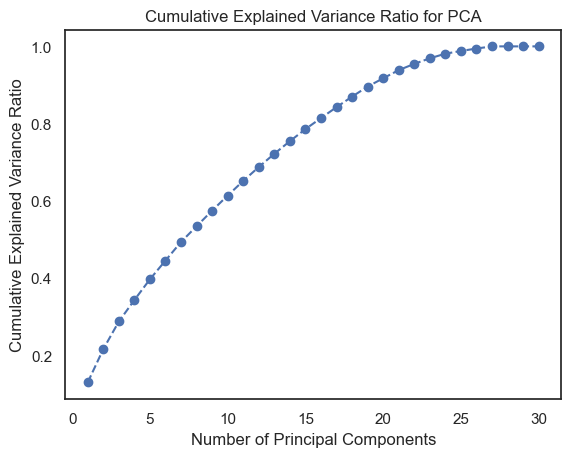

In [32]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can use other strategies like 'median' or 'most_frequent'
numerical_features_imputed = pd.DataFrame(imputer.fit_transform(numerical_features), columns=numerical_features.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features_imputed)

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(numerical_features_scaled)

# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.show()

In [33]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X2 = wide_df.drop(["surg_engel", "surg_engel___1", "surg_engel___2", "surg_engel___3",
                   "surg_engel___4", "engel_class1", "engel_class2", "engel_class3",
                   "engel_class4",], axis=1)
# Extract numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).copy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(numerical_features, y, test_size=0.2, random_state=42)

# Impute missing values separately for training and testing sets
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Data preprocessing (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Perform PCA
pca = PCA(n_components=20)  # Choose the number of components based on your analysis
pca_result_train = pca.fit_transform(X_train_scaled)
pca_result_test = pca.transform(X_test_scaled)

# Create a Support Vector Machine
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier on the training data
svc.fit(pca_result_train, y_train)

# Make predictions on the test data
y_pred = svc.predict(pca_result_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.62


## Print system information

In [34]:
import session_info

session_info.show()

KeyError: 'pybind11_abseil'